### Imports

In [1]:
import hashlib
import joblib
import random
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords as sw
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/remote_ssh_user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/remote_ssh_user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Utils

In [3]:
SEED = 111

random.seed(SEED)
np.random.seed(SEED)

### Data preparation

In [4]:
dataset = pd.read_json('../data/dataset_2weeks.jsonl', lines=True)
dataset = dataset[dataset.type.eq('edit')].reset_index(drop=True)

In [5]:
def clean_text(text: pd.DataFrame) -> pd.DataFrame:
    """
    Function that cleans the text by removing stopwords and lemmatizing the words
    """
    stopwords = sw.words('english')
    lemmatizer = WordNetLemmatizer()

    text = text.str.lower()
    text = text.str.replace('[^\w\s]', '')
    text = text.str.replace('\d+', '')
    text = text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stopwords]))
    return text

def transform_data(dataset):
    """Converts the dataset into a format that can be used by the classifier"""
    result = pd.DataFrame(index=dataset.user.unique())
    result['bot'] = dataset.groupby('user').bot.max()
    result['bot_in_name'] = result.index.map(lambda x: 'bot' in x.lower())

    dataset['bot_in_comment'] = dataset.comment.str.lower().str.contains('bot')
    result['bot_in_comment'] = dataset.groupby('user').bot_in_comment.mean() > 0.5

    dataset['day'] = dataset.timestamp.dt.day
    dataset['hour'] = dataset.timestamp.dt.hour
    result['changes_per_day'] = dataset.groupby(['day', 'user']).day.count().groupby('user').mean()
    result['changes_per_day_min'] = dataset.groupby(['day', 'user']).day.count().groupby('user').min()
    result['changes_per_day_max'] = dataset.groupby(['day', 'user']).day.count().groupby('user').max()

    result['changes_per_hour'] = dataset.groupby(['hour', 'day', 'user']).hour.count().groupby('user').mean()
    result['changes_per_hour_min'] = dataset.groupby(['hour', 'day', 'user']).hour.count().groupby('user').min()
    result['changes_per_hour_max'] = dataset.groupby(['hour', 'day', 'user']).hour.count().groupby('user').max()

    dataset['edit_length'] = dataset.length.apply(lambda x: abs(x['old'] - x['new']) if x else 0)
    result['edit_length_mean'] = dataset.groupby('user').edit_length.mean()
    result['edit_length_min'] = dataset.groupby('user').edit_length.min()
    result['edit_length_max'] = dataset.groupby('user').edit_length.max()

    result['pages_edited'] = dataset.groupby('user').title.nunique()
    result['pages_edited_per_day'] = dataset.groupby(['day', 'user']).title.nunique().groupby('user').mean()
    result['pages_edited_per_day_min'] = dataset.groupby(['day', 'user']).title.nunique().groupby('user').min()
    result['pages_edited_per_day_max'] = dataset.groupby(['day', 'user']).title.nunique().groupby('user').max()

    result['pages_edited_per_hour'] = dataset.groupby(['hour', 'day', 'user']).title.nunique().groupby('user').mean()
    result['pages_edited_per_hour_min'] = dataset.groupby(['hour', 'day', 'user']).title.nunique().groupby('user').min()
    result['pages_edited_per_hour_max'] = dataset.groupby(['hour', 'day', 'user']).title.nunique().groupby('user').max()

    tfidf = TfidfVectorizer(max_features=10)
    tfidf.fit(clean_text(dataset.comment))
    tfidf_columns = [f'tfidf_{feature}' for feature in tfidf.get_feature_names_out()]
    tfidf_data = pd.DataFrame(tfidf.transform(dataset.comment).toarray(), columns=tfidf_columns).fillna(0)
    dataset = pd.concat([dataset, tfidf_data], axis=1)
    result[tfidf_columns] = dataset.groupby('user')[tfidf_columns].mean()

    return result

In [6]:
transformed_dataset = transform_data(dataset)
transformed_dataset

,bot,bot_in_name,bot_in_comment,changes_per_day,changes_per_day_min,changes_per_day_max,changes_per_hour,changes_per_hour_min,changes_per_hour_max,edit_length_mean,...,tfidf_added,tfidf_bot,tfidf_category,tfidf_en,tfidf_link,tfidf_report,tfidf_talk,tfidf_user,tfidf_wikipedia,tfidf_wp
GreenC bot,True,True,False,1566.571429,2,9771,378.137931,1,2003,56.608700,...,0.000000,0.000207,0.000000,0.000000,0.014471,0.00023,0.000000,0.981196,0.036553,0.000000
77.76.22.175,False,False,False,1.000000,1,1,1.000000,1,1,45.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Immanuelle,False,False,False,243.500000,74,562,21.485294,1,69,1418.531143,...,0.154492,0.000000,0.168069,0.000675,0.001463,0.00000,0.007548,0.008360,0.071725,0.240121
DatBot,True,True,True,202.285714,151,234,9.076923,1,128,96.045904,...,0.000000,0.623373,0.000000,0.000000,0.000000,0.00000,0.000000,0.429057,0.333058,0.275939
141.136.148.132,False,False,False,26.000000,26,26,26.000000,26,26,5.461538,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82.196.120.14,False,False,False,2.000000,2,2,2.000000,2,2,2.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
154.230.28.59,False,False,False,1.000000,1,1,1.000000,1,1,115.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2600:8804:986:3600:5509:7788:B8C:71D9,False,False,False,2.000000,2,2,2.000000,2,2,36.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Jsjn1129,False,False,False,1.000000,1,1,1.000000,1,1,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


### Train classifier

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

In [8]:
transformed_dataset.bot.value_counts()

bot
False    38633
True        29
Name: count, dtype: int64

In [96]:
train_set, validation_set = train_test_split(transformed_dataset, test_size=0.4, random_state=SEED, stratify=transformed_dataset.bot)

In [97]:
train_set.bot.value_counts()

bot
False    23180
True        17
Name: count, dtype: int64

In [98]:
K = 3

users_train_set = train_set[train_set.bot == False]
bots_train_set = train_set[train_set.bot == True]

users_downsampled = resample(users_train_set.drop_duplicates(), replace=False, n_samples=int(len(bots_train_set) * K), random_state=SEED)

train_set = pd.concat([bots_train_set.drop_duplicates(), users_downsampled.drop_duplicates()])

In [99]:
train_set.value_counts('bot')

bot
False    51
True     17
Name: count, dtype: int64

In [100]:
def plot_conf_matrix(conf_matrix):
    """Plots a confusion matrix"""
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [101]:
rf_model = RandomForestClassifier(random_state=SEED)

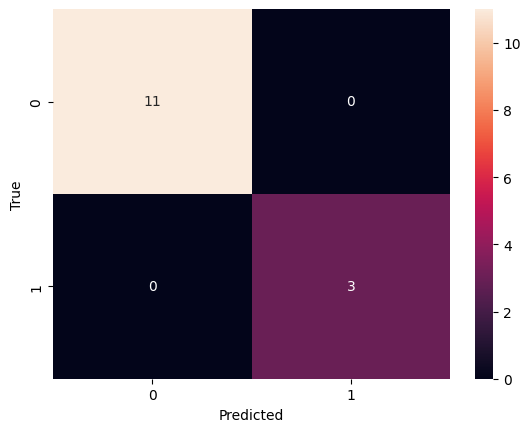

F1 score: 1.0


In [102]:
X_train, X_test, y_train, y_test = train_test_split(train_set.drop(['bot'], axis=1), train_set['bot'], test_size=0.2, random_state=SEED)

model = rf_model.fit(X_train, y_train)
score = f1_score(y_test, model.predict(X_test))
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
plot_conf_matrix(conf_matrix)
print(f'F1 score: {score}')

In [103]:
grid_search_params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 50, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 500],
    }

grid = GridSearchCV(estimator=rf_model, param_grid=grid_search_params, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=111),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 50, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1')

In [104]:
grid.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [105]:
grid.best_score_

0.9714285714285715

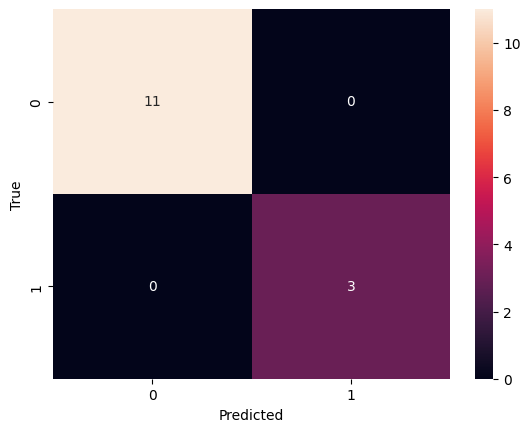

F1 score: 1.0


In [106]:
rf_model = RandomForestClassifier(random_state=SEED, **grid.best_params_)
model = rf_model.fit(X_train, y_train)
score = f1_score(y_test, model.predict(X_test))
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
plot_conf_matrix(conf_matrix)
print(f'F1 score: {score}')

In [107]:
feature_importance = pd.DataFrame(model.feature_importances_, X_train.columns).reset_index()
feature_importance.columns = ['feature_name', 'feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_name,feature_importance
0,bot_in_name,0.380646
2,changes_per_day,0.093815
1,bot_in_comment,0.073774
4,changes_per_day_max,0.065882
12,pages_edited_per_day,0.063775
11,pages_edited,0.060192
14,pages_edited_per_day_max,0.034833
10,edit_length_max,0.029575
15,pages_edited_per_hour,0.028821
8,edit_length_mean,0.027331


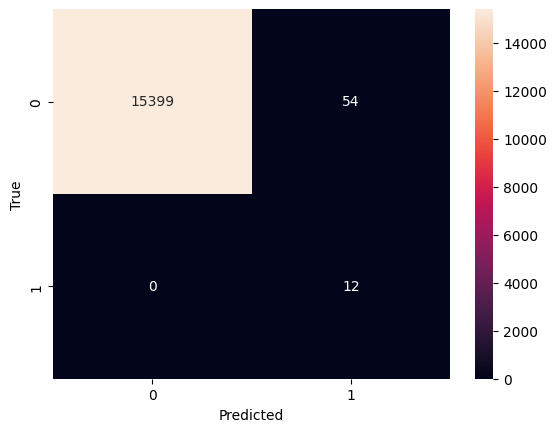

In [108]:
plot_conf_matrix(confusion_matrix(validation_set['bot'], model.predict(validation_set.drop(['bot'], axis=1)), ))

In [110]:
y_val = validation_set['bot']
X_val = validation_set.drop(['bot'], axis=1)
X_pred = model.predict(X_val)

print(classification_report(y_val, X_pred))
print(f'F1 score: {f1_score(y_val, X_pred)}')

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     15453
        True       0.18      1.00      0.31        12

    accuracy                           1.00     15465
   macro avg       0.59      1.00      0.65     15465
weighted avg       1.00      1.00      1.00     15465

F1 score: 0.3076923076923077


In [114]:
# Save model
joblib.dump(model, '../data/bot_classifier.joblib')

['../data/bot_classifier.joblib']